In [2648]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
from matplotlib import pyplot as plt

In [2649]:
WG = .02 # Defines how much wealth grows each period
TR = .2 #Tax Rate

In [2650]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

In [2651]:
ppl0 = pd.DataFrame({'Name': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'], 'W': [1,2,3,4,5,6,7,8,9,10]}) #base values of the first generation
ppl0['WRich'] = ppl0.apply(lambda row: True if row['W'] >= np.mean(ppl0.W) else False, axis=1) #Says if they are wealth rich, meaning above average
ppl0['IRich'] = False #No income yet, they are all not income rich
ppl0["Income"] = 0
ppl0["Taxed"] = 0
ppl0["SB"] = .1*(ppl0['W']/max(ppl0['W']))  #Random change buffer, higher value means higher avg expected draw. Is proportional to wealth compared to max
ppl0["Vote"] = ppl0.apply(lambda row: False if row['WRich'] == True else True, axis=1) # Rich people vote no for redistrobution #will be based on probabilities and wealth later


In [2652]:
ppl = [ppl0] #creates list of generations of people
elect = [False] #Creates a list that will collect all election outcomes
G = [gini(ppl0['W'])]
ppl[0]

,Name,W,WRich,IRich,Income,Taxed,SB,Vote
0,A,1,False,False,0,0,0.01,True
1,B,2,False,False,0,0,0.02,True
2,C,3,False,False,0,0,0.03,True
3,D,4,False,False,0,0,0.04,True
4,E,5,False,False,0,0,0.05,True
5,F,6,True,False,0,0,0.06,False
6,G,7,True,False,0,0,0.07,False
7,H,8,True,False,0,0,0.08,False
8,I,9,True,False,0,0,0.09,False
9,J,10,True,False,0,0,0.10,False


In [2653]:
def NextPeriod():
    t = len(ppl) ## current period
    ppl.append(ppl[t - 1].copy()) ## creates copy of previous period
    
    Outcome = False #Outcome of vote is not to tax unless vote otherwise
    if ppl[t - 1]["Vote"].value_counts()[True] >= ppl[t - 1]["Vote"].value_counts()[False]: Outcome = True
    elect.append(Outcome)
    
    ppl[t]['Income'] = ppl[t]['W']*(WG) ## calculates income fro individual (wealth * wealth growth rate) 
    ppl[t]['Income'] = ppl[t].apply(lambda row: row['Income'] 
                        + (row['W'] * np.random.normal(loc=row['SB'], scale=.1)) #+ random chance income, proportional to wealth, adjusted buffer for wealth
                        + (sum(ppl[t-1]['Taxed']) * np.random.beta(a = 3, b = 3*(len(ppl[t]) - 1))), axis = 1) #+ benefits of taxes through investment, on average all the benefits of the tax are distributed #using beta distrobution
    ## I hope you know I am actually really claver for figuring out how to create a beta distrobution with a set mean
    MeanI = np.mean(ppl[t]['Income']) ## Defining Mean Wealth
    
    ppl[t]['IRich'] = ppl[t].apply(lambda row: True if row['Income'] >= MeanI else False, axis=1) #Says if they are income rich, meaning above average
    ppl[t]["Taxed"] = ppl[t].apply(lambda row: (row['Income'] - MeanI)*TR if row['IRich'] == True else 0, axis=1) #calculates how much was taxed
    
    ppl[t]['W'] = ppl[t]['W'] + ppl[t]['Income'] - ppl[t]["Taxed"] ## Adds income to 
    ppl[t]['W'] = ppl[t].apply(lambda row: max(1, row['W']), axis = 1) ## min wealth is 1
    
    MeanW = np.mean(ppl[t]['W']) ## Defining Mean Wealth
    ppl[t]['WRich'] = ppl[t].apply(lambda row: True if row['W'] >= MeanW else False, axis=1) #Says if they are rich, meaning above average
    ppl[t]["SB"] = 0 # irrelavent, too powerful #.1*(ppl[t]['W']/max(ppl[t]['W'])) #chance buffer proportional to wealth compared to max wealth
    ppl[t]["Vote"] = ppl[t].apply(lambda row: False if row['WRich'] == True else True, axis=1) # Rich people vote no for redistrobution #will be based on probabilities and wealth later
    
    G.append(gini(ppl[t]['W']))
    
    return t

In [2654]:
def GraphNextWealth():
    t = NextPeriod() #calls the function creating the next period and returns the current period t and voting outcome
    GraphW = sns.barplot(data=ppl[t], x="Name", y="W", estimator= 'mean', order = ppl[t].sort_values('W').Name) #Wealth distrobution graph
    GraphW.set(title = f"Wealth in Period {t}, Outcome is {elect[t]}, Gini is {G[t]:.3f}", label = True) #, ybound=[0,50],)
    GraphW.bar_label(GraphW.containers[0])
    GraphW.axhline(y = np.mean(ppl[t]['W']), color = 'darkgreen')

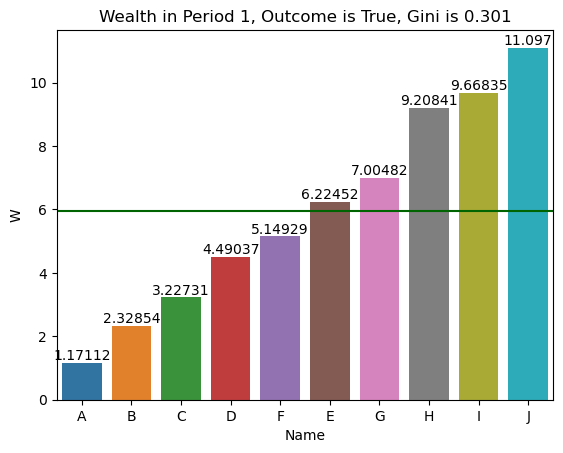

In [2655]:
GraphNextWealth()

In [2656]:
def run100():
    for i in range(100): NextPeriod()

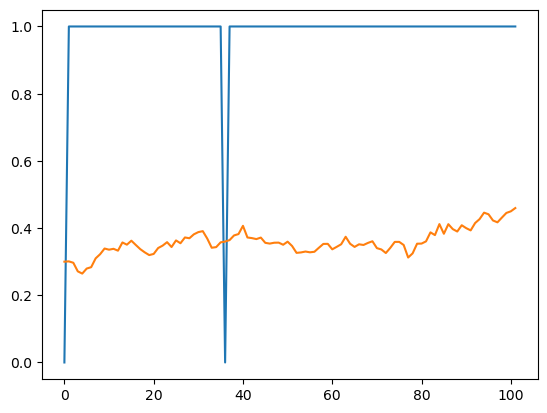

In [2657]:
run100()
plt.plot(elect)
plt.plot(G)

In [2658]:
## Next
## Change voting to be based on percieved outcomes
## Delay voting / median Income, so probibility that they will be taxed in the period
## Calculate the inequality and making voting based on that
## collect the data and average over several times
## iterate over different r
## gini is actuallly good for measuring the distrobution but bad for advising next steps, or measuring the changes and directions of inequality
## Can change election laws, see impact